# 초기 설정 (마운트, 경로설정, 라이브러리 임포트)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/column_shap

/content/drive/MyDrive/Colab Notebooks/column_shap


In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway
from sklearn.datasets import fetch_openml
from scipy.stats import ks_2samp
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize
import itertools

In [5]:
!pip install tqdm  # tqdm 라이브러리 설치
from tqdm import tqdm  # tqdm 임포트

# 1차 함수 선언

100개 train/test split data set 뽑기

In [6]:
def train_test_index(X_tmp,y_tmp,num):
  same_check=[0]
  while 0 in same_check:
    count=-1
    df_index_test=pd.DataFrame(columns=range(num))
    df_index_train=pd.DataFrame(columns=range(num))
    for ii in range(num):
      count_false_X=100
      count_false_y=100
      while  count_false_y>0:
        X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp,test_size=0.2,random_state=None,shuffle=True)
        mean_threshold_y=0.01*y_tmp.mean()
        std_threshold_y = 0.1 * y_tmp.std()
        a1=np.abs(y_tmp.mean()-y_train.mean())<mean_threshold_y
        a2=np.abs(y_tmp.mean()-y_test.mean())<mean_threshold_y
        a3=np.abs(y_tmp.std()-y_train.std())<std_threshold_y
        a4=np.abs(y_tmp.std()-y_test.std())<std_threshold_y
        data=a1,a2,a3,a4
        count_false_y=0
        for value in data:
          if value == False:
              count_false_y += 1
      df_index_test[ii]=sorted(X_test.index.tolist())
      df_index_train[ii]=sorted(X_train.index.tolist())
    # create dataframe with two empty columns
    dice = pd.DataFrame(columns=['col1', 'col2'])
    # loop through 10 natural numbers and randomly select two different numbers for each row
    for i in range(1, num+1):
        numbers = random.sample(range(0, num), 2)
        dice.loc[i-1] = numbers
    same_check=[]
    for i in range(num):
      same_check_tmp=np.sum(df_index_test[dice.iloc[i][0]]-df_index_test[dice.iloc[i][1]])
      same_check.append(same_check_tmp)
    count+=1
  return df_index_train, df_index_test


1개 train/test split data set 뽑기

In [7]:
def train_test_index2(X_tmp,y_tmp):
  df_index_test=pd.DataFrame(columns=range(1))
  df_index_train=pd.DataFrame(columns=range(1))
  count_false_X=100
  count_false_y=100
  while  count_false_y>0:
  # Load your dataset as a Pandas DataFrame
    X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp,test_size=0.2,random_state=None,shuffle=True)
    mean_threshold_y=0.1*y_tmp.mean()
    std_threshold_y = 0.1 * y_tmp.std()
    a1=np.abs(y_tmp.mean()-y_train.mean())<mean_threshold_y
    a2=np.abs(y_tmp.mean()-y_test.mean())<mean_threshold_y
    a3=np.abs(y_tmp.std()-y_train.std())<std_threshold_y
    a4=np.abs(y_tmp.std()-y_test.std())<std_threshold_y
    data=a1,a2,a3,a4
    count_false_y=0
    for value in data:
      if value == False:
          count_false_y += 1
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  return df_index_train, df_index_test

초기 파라메터 튜닝

In [8]:
def initial_tuning(X_tmp,y_tmp):
  base_score_value=np.mean(y_tmp)
  model = xgb.XGBRegressor(objective='reg:squarederror',
                          base_score=base_score_value)
  X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp, test_size=0.2, random_state=None,shuffle=True)
  param_grid = {
      'max_depth': [3,5,7],
      'min_child_weight': [0.05,0.075,0.1],
      'gamma': [0.001,0.005,0.01,0.015,0.02],
      'reg_alpha': [0.01,0.05,0.1],
      'reg_lambda': [0.01,0.05,0.1],
  }
  df_param_grid=pd.DataFrame(param_grid.items())

  param_step1 = {
      df_param_grid.iloc[0,0]: df_param_grid.iloc[0,1],
      df_param_grid.iloc[1,0]: df_param_grid.iloc[1,1],
  }

  grid_search_step1 = GridSearchCV(model, param_grid=param_step1, cv=10, n_jobs=-1,scoring='neg_mean_squared_error')
  grid_search_step1.fit(X_train, y_train)

  model_0 = xgb.XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_)
  ## step 2
  param_step2 = {
      df_param_grid.iloc[2,0]: df_param_grid.iloc[2,1],
      df_param_grid.iloc[3,0]: df_param_grid.iloc[3,1],
      df_param_grid.iloc[4,0]: df_param_grid.iloc[4,1],
  }
  grid_search_step2 = GridSearchCV(model_0, param_grid=param_step2, cv=10, n_jobs=-1)
  grid_search_step2.fit(X_train, y_train)

  step1_best_params_=grid_search_step1.best_params_
  step2_best_params_=grid_search_step2.best_params_
  return step1_best_params_,step2_best_params_

In [9]:
def objective_func(particle,X,y):
    # Convert particle values to appropriate format
    learning_rate = particle[0]
    max_depth = int(particle[1])
    min_child_weight = particle[2]
    gamma=particle[3]
    reg_alpha=particle[4]
    reg_lambda=particle[5]
    base_score_value=np.median(y)
    # Create an XGBoost regression model with the specified hyperparameters
    model = XGBRegressor(objective='reg:squarederror',
                         base_score=base_score_value,
                         learning_rate=learning_rate,
                         max_depth=max_depth,
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         )
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=None,shuffle=True)
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)

    return -r2 # Negative sign to maximize the R-squared

In [10]:
def initial_tunning_pso(X,y):
  bounds = [(0.05, 0.2),  # Learning rate
                  (3, 10),       # Max depth
                  (0.05, 0.2),  # Min child weight
                  (0,0.02),  #gamma
                  (0,0.1), #reg_alpha
                  (0, 0.1)]    #reg_lambda
  # Define the number of particles
  n_particles = 10
  # Initialize the best cost and best position
  best_cost = np.inf
  best_pos = None

  # Run the PSO algorithm
  for _ in range(10):
      # Generate random particles within the bounds
      particles = np.random.uniform(low=[b[0] for b in bounds], high=[b[1] for b in bounds], size=(n_particles, len(bounds)))
      # print(particles)
      # Evaluate the objective function for each particle
      costs = np.array([objective_func(p,X,y) for p in particles])

      # Update the best cost and best position
      best_index = np.argmin(costs)
      if costs[best_index] < best_cost:
          best_cost = costs[best_index]
          best_pos = particles[best_index]
  base_score_value=np.mean(y)
  model = XGBRegressor(objective='reg:squarederror',
                      base_score=base_score_value,
                      learning_rate=best_pos[0],
                      max_depth=int(best_pos[1]),
                      min_child_weight=best_pos[2],
                      gamma=best_pos[3],
                      reg_alpha=best_pos[4],
                      reg_lambda=best_pos[5],)
  return best_cost, model

In [11]:
def model_initial2(target_num,num2,model):
  X,y=data_input(target_num)
  num2=num2
  r2_test=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test=train_test_index(X,y,num2)

  for i in range(num2):
    X_train=X.loc[df_index_train[i]]
    y_train=y.loc[df_index_train[i]]
    X_test=X.loc[df_index_test[i]]
    y_test=y.loc[df_index_test[i]]


    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    r2_train_result.append(r2_train)
    r2_test_result.append(r2_test)
  return r2_test_result

In [12]:
def model_initial(target_num,num2,step1_best_params_,step2_best_params_):
  X,y=data_input(target_num)
  base_score_value=np.median(y)
  model = xgb.XGBRegressor(objective='reg:squarederror',
                        base_score=base_score_value,
                        **step1_best_params_,
                        **step2_best_params_)
  num2=num2
  r2_test=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test=train_test_index(X,y,num2)

  for i in range(num2):
    X_train=X.loc[df_index_train[i]]
    y_train=y.loc[df_index_train[i]]
    X_test=X.loc[df_index_test[i]]
    y_test=y.loc[df_index_test[i]]


    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    r2_train_result.append(r2_train)
    r2_test_result.append(r2_test)
  return r2_test_result

# 2차 함수 선언

## 데이터베이스 입력+data preprocessing

In [13]:
def data_input(target_num):
  if target_num == 3 or target_num == 6:
    df_tmp = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')
    df=df_tmp.dropna(); # DS4 일때만
  else:
    df = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')  # 나머지

  pt = PowerTransformer(method='yeo-johnson')
  minmax = MinMaxScaler()
  trans = pt.fit_transform(df)
  df_trans=pd.DataFrame(trans)
  df_trans[df_trans.columns]=minmax.fit_transform(df_trans[df_trans.columns])
  df_output=df_trans.iloc[:, 20:27]
  df_input=df_trans.iloc[:,0:20]
  X = df_input
  y = df_output.iloc[:,target_num]
  # ["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
  return X,y

In [14]:
def data_input2(target_num):
  # df_tmp = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')
  # df=df_tmp.dropna(); # DS4 일때만
  if target_num==3 or target_num == 6:
    df_tmp = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')
    df=df_tmp.dropna(); # DS4 일때만
  else:
    df = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')  # 나머지

  pt = PowerTransformer(method='yeo-johnson')
  minmax = MinMaxScaler()
  trans = pt.fit_transform(df)
  df_trans=pd.DataFrame(trans)
  df_trans[df_trans.columns]=minmax.fit_transform(df_trans[df_trans.columns])
  df_output=df_trans.iloc[:, 20:27]
  df_input=df_trans.iloc[:,0:20]
  X = df_input
  y = df_output.iloc[:,target_num]
  # ["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
  return X,y

## 이상치제거

In [15]:
def outlier_eliminater(X,y,num,var1,var2,var3,step1_best_params_,step2_best_params_):
  threshold = (y.mean() * var1) ** 2
  X_rsod=X
  y_rsod=y
  num=num
  remove_ind=[]
  remove_df = pd.DataFrame(index=range(round(0.2*len(y_rsod))), columns=range(num))
  # step1_best_params_,step2_best_params_ = initial_tuning(X_rsod,y_rsod)
  for iii in range (num): # outlier list 만들어 낼 case 개수
    remove_list=[]
    while len(remove_list)<var2: # 빈도 파악할 outlier 개수
      min_score = 1000
      base_score_value=np.median(y_rsod)
      for i in range(1): # removing set의 필터링
        df_index_train,df_index_test=train_test_index2(X_rsod,y_rsod)
        X_train=X_rsod.loc[df_index_train]
        y_train=y_rsod.loc[df_index_train]
        X_test=X_rsod.loc[df_index_test]
        y_test=y_rsod.loc[df_index_test]
        model = xgb.XGBRegressor(objective='reg:squarederror',
                              base_score=base_score_value,
                              **step1_best_params_,
                              **step2_best_params_
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        score = mean_squared_error(y_test, preds)**0.5
        if score < min_score:
          remove_train = X_test
          remove_test = preds
          min_score = score

      pred_value = remove_test.tolist()
      remove_set = remove_train.reset_index()["index"].to_list()
      real_value = []

      for ii in remove_set:
        real_value.append(y[ii])

      count = 0
      for p, r in zip(pred_value, real_value):
        temp = (p - r) ** 2
        if temp > threshold:
          remove_ind.append(remove_set[count])
        count += 1

      remove_list.extend(remove_ind)
      X_rsod=X.drop(remove_list,axis=0)
      y_rsod=y.drop(remove_list,axis=0)
      remove_ind=[]
      for a in range  (len(remove_list)):
        remove_df[iii][a]=remove_list[a]

  tmp=remove_df.values.flatten().tolist()
  ttmp=[x for x in tmp if not pd.isna(x)]
  counts = Counter(ttmp)
  # Get the 5 most common values and their counts
  top_5 = counts.most_common(round(var3*len(y)))  # 최종 제거할 outlier 개수
  real_remove_df=pd.DataFrame(top_5)[0]

  X_rsod=X.drop(real_remove_df,axis=0)
  y_rsod=y.drop(real_remove_df,axis=0)
  return X_rsod,y_rsod,real_remove_df,model

In [16]:
def model_rsod(target_num,num,num2,var1,var2,var3,step1_best_params_,step2_best_params_):
  X,y=data_input(target_num)
  X_rsod,y_rsod,real_remove_df,model =outlier_eliminater(X,y,num,var1,var2,var3,step1_best_params_,step2_best_params_) #이상치 제거
  base_score_value=np.median(y)
  # step1_best_params_,step2_best_params_  =  initial_tuning(X_rsod,y_rsod)
  model = xgb.XGBRegressor(objective='reg:squarederror',
                        base_score=base_score_value,
                        **step1_best_params_,
                        **step2_best_params_)
  num2=num2
  r2_test=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test=train_test_index(X_rsod,y_rsod,num2)

  for i in range(num2):
    X_train=X_rsod.loc[df_index_train[i]]
    y_train=y_rsod.loc[df_index_train[i]]
    X_test=X_rsod.loc[df_index_test[i]]
    y_test=y_rsod.loc[df_index_test[i]]


    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    r2_train_result.append(r2_train)
    r2_test_result.append(r2_test)
  return r2_test_result,X_rsod,y_rsod

## 차원축소

In [17]:
def fs1(X_rsod,y_rsod,num,step1_best_params_,step2_best_params_):
  num=num
  ranking_df = pd.DataFrame(index=range(X_rsod.shape[1]), columns=range(num))
  # step1_best_params_,step2_best_params_  =  initial_tuning(X_rsod,y_rsod)
  base_score_value=np.mean(y_rsod)
  df_index_train,df_index_test=train_test_index(X_rsod,y_rsod,num)
  for i in range(num):
    X_train=X_rsod.loc[df_index_train[i]]
    y_train=y_rsod.loc[df_index_train[i]]
    X_test=X_rsod.loc[df_index_test[i]]
    y_test=y_rsod.loc[df_index_test[i]]
    model_fs1 = XGBRegressor(objective='reg:squarederror',
                                  base_score=base_score_value,
                                  **step1_best_params_,
                                  **step2_best_params_
                                  )
    model_fs1.fit(X_train, y_train)
    importances = model_fs1.feature_importances_

    # Print the feature importances in descending order
    indices = importances.argsort()[::-1]
    ranking_df[i]=indices

  row_avg = ranking_df.mean(axis=1)
  good_feature=row_avg[row_avg<np.mean(row_avg)+0.5].index
  X_fs1=X_rsod.iloc[:, good_feature]
  y_fs1=y_rsod
  return X_fs1,y_fs1,model_fs1

## 튜닝

In [18]:
# tuning 수행할 dataset 탐색
def tuning_dataset(X_fs1,y_fs1,num,model_fs1):
  num=num
  r2_test_hype=0
  r2_train_hype_result=[]
  r2_test_hype_result=[]
  df_index_train,df_index_test=train_test_index(X_fs1,y_fs1,num)
  for ii in range(num):
    X_train=X_fs1.loc[df_index_train[ii]]
    y_train=y_fs1.loc[df_index_train[ii]]
    X_test=X_fs1.loc[df_index_test[ii]]
    y_test=y_fs1.loc[df_index_test[ii]]

    model_fs1.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model_fs1.predict(X_test)
    y_train_pred = model_fs1.predict(X_train)

    # Compute the R-squared for the test set
    r2_train_hype = r2_score(y_train,y_train_pred)
    r2_test_hype = r2_score(y_test,y_test_pred)
    r2_train_hype_result.append(r2_train_hype)
    r2_test_hype_result.append(r2_test_hype)

  max_r2= max(r2_test_hype_result)
  max_index = r2_test_hype_result.index(max_r2)
  i=max_index
  X_train=X_fs1.loc[df_index_train[i]]
  y_train=y_fs1.loc[df_index_train[i]]
  X_test=X_fs1.loc[df_index_test[i]]
  y_test=y_fs1.loc[df_index_test[i]]

  return X_train,y_train,X_test,y_test,df_index_test[i]

In [19]:
def tuning(X_train,y_train,X_test,y_test,model_fs1):
  param_grid = {
      'learning_rate': [0.075,0.1,0.125,0.15],
      'subsample': [0.1,0.2,0.35,0.5],
      'colsample_bytree': [0.25,0.5,0.75,1],
      'n_estimators': [70,100,120,150],
      'max_depth': [3,5,7,9],
      'min_child_weight': [0.001,0.0025,0.005,0.0075,0.01],
      'scale_pos_weight':[0.001,0.0025,0.005,0.0075,0.01],
      'gamma': [0.003,0.005,0.007,0.01],
      'reg_alpha': [0.02,0.025,0.03,0.05],
      'reg_lambda': [0.075,0.01,0.0125,0.015],
  }
  df_param_grid=pd.DataFrame(param_grid.items())
  base_score_value=np.mean(y_fs1)
  # df_index_train,df_index_test=train_test_index2(X_fs1,y_fs1)
  # X_train=X_fs1.loc[df_index_train]
  # y_train=y_fs1.loc[df_index_train]
  # X_test=X_fs1.loc[df_index_test]
  # y_test=y_fs1.loc[df_index_test]
  ## step 1
  param_step1 = {
      df_param_grid.iloc[0,0]: df_param_grid.iloc[0,1],
      df_param_grid.iloc[1,0]: df_param_grid.iloc[1,1]
  }
  grid_search_step1 = GridSearchCV(model_fs1, param_grid=param_step1, cv=10, n_jobs=-1,scoring='neg_mean_squared_error')
  grid_search_step1.fit(X_train, y_train)

  model_hype = xgb.XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_)

  ## step 2
  param_step2 = {
      df_param_grid.iloc[2,0]: df_param_grid.iloc[2,1],
      df_param_grid.iloc[3,0]: df_param_grid.iloc[3,1]
  }
  grid_search_step2 = GridSearchCV(model_hype, param_grid=param_step2, cv=10, n_jobs=-1)
  grid_search_step2.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_)

  # step 3
  param_step3 = {
      df_param_grid.iloc[4,0]: df_param_grid.iloc[4,1],
      df_param_grid.iloc[5,0]: df_param_grid.iloc[5,1]
  }
  grid_search_step3 = GridSearchCV(model_hype, param_grid=param_step3, cv=10, n_jobs=-1)
  grid_search_step3.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_)

  # step 4
  param_step4 = {
      df_param_grid.iloc[6,0]: df_param_grid.iloc[6,1],
      df_param_grid.iloc[7,0]: df_param_grid.iloc[7,1]
  }
  grid_search_step4 = GridSearchCV(model_hype, param_grid=param_step4, cv=10, n_jobs=-1)
  grid_search_step4.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_,
                                **grid_search_step4.best_params_)

  # step 5
  param_step5 = {
      df_param_grid.iloc[8,0]: df_param_grid.iloc[8,1],
      df_param_grid.iloc[9,0]: df_param_grid.iloc[9,1]
  }
  grid_search_step5 = GridSearchCV(model_hype, param_grid=param_step5, cv=10, n_jobs=-1)
  grid_search_step5.fit(X_train, y_train)

  model_hype_result = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_,
                                **grid_search_step4.best_params_,
                                **grid_search_step5.best_params_)

  return model_hype_result

## 성능평가

In [20]:
# tuning 수행된 모델 성능 평가
def model_eval_100(X_fs1,y_fs1,model_hype_result):
  num=100
  r2_test_hype=0
  r2_train_hype_result=[]
  r2_test_hype_result=[]
  df_index_train,df_index_test=train_test_index(X_fs1,y_fs1,num)
  for ii in range(num):
    X_train=X_fs1.loc[df_index_train[ii]]
    y_train=y_fs1.loc[df_index_train[ii]]
    X_test=X_fs1.loc[df_index_test[ii]]
    y_test=y_fs1.loc[df_index_test[ii]]

    model_hype_result.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model_hype_result.predict(X_test)
    y_train_pred = model_hype_result.predict(X_train)

    # Compute the R-squared for the test set
    r2_train_hype = r2_score(y_train,y_train_pred)
    r2_test_hype = r2_score(y_test,y_test_pred)

    r2_train_hype_result.append(r2_train_hype)
    r2_test_hype_result.append(r2_test_hype)

  max_r2= max(r2_test_hype_result)
  max_index = r2_test_hype_result.index(max_r2)
  i=max_index
  X_train=X_fs1.loc[df_index_train[i]]
  y_train=y_fs1.loc[df_index_train[i]]
  X_test=X_fs1.loc[df_index_test[i]]
  y_test=y_fs1.loc[df_index_test[i]]
  return X_train,y_train,X_test,y_test,df_index_train[i],df_index_test[i],max_r2,r2_test_hype_result

In [21]:
def cv_model_eval(model_hype_result,X_fs1,y_fs1):
  avg_r2_hype=0
  cv_results_r2_hype = []
  df_index_train,df_index_test=train_test_index2(X_fs1,y_fs1)
  X_train=X_fs1.loc[df_index_train]
  y_train=y_fs1.loc[df_index_train]
  for _ in range(10):
    avg_r2_hype_result=[]
    kfold=KFold(n_splits=10, shuffle=True,random_state=None)
    for train_index, val_index in kfold.split(X_train):
        X_train_k, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_k, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        model_hype_result.fit(X_train_k, y_train_k)
        y_val_pred = model_hype_result.predict(X_val)
        r2_hype=r2_score(y_val, y_val_pred)
        avg_r2_hype_result.append(r2_hype)
    cv_results_r2_hype.append(np.mean(avg_r2_hype_result))
  return cv_results_r2_hype

## 결과 뽑기

In [22]:
def result(X_train,y_train,X_test,y_test,df_index_train,df_index_test,model_hype_result):
  # max_r2= max(r2_test_hype_result)
  # max_index = r2_test_hype_result.index(max(r2_test_hype_result))
  # ii=max_index
  # X_train=X_fs1.loc[df_index_train[ii]]
  # y_train=y_fs1.loc[df_index_train[ii]]
  # X_test=X_fs1.loc[df_index_test[ii]]
  # y_test=y_fs1.loc[df_index_test[ii]]
  model_hype_result.fit(X_train, y_train)
  y_train_pred=model_hype_result.predict(X_train)
  y_test_pred = model_hype_result.predict(X_test)
  r2_test_hype = r2_score(y_test,y_test_pred)
  array_1=df_index_test.to_numpy()
  array_2=y_test
  array_3=y_test_pred
  array_4=df_index_train.to_numpy()
  array_5=y_train
  array_6=y_train_pred
  result_df2 = pd.DataFrame({'index': array_1, 'real': array_2, 'preds': array_3})
  result_df1= pd.DataFrame({'index': array_4, 'real': array_5, 'preds': array_6})
  return result_df1,result_df2

## 역변환

In [23]:
def inverse_transe(result_df,target_num):
  if target_num==3:
    df_tmp = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')
    df=df_tmp.dropna(); # DS4 일때만
  else:
    df = pd.read_csv("./(0417)df_columns_parameters_corr.csv", encoding='cp949')  # 나머지

  df.astype('float')
  df_output=df.iloc[:, 20:27]
  df_input=df.iloc[:,0:20]

  X = df_input
  y = np.array(df_output.iloc[:,target_num])

  pt = PowerTransformer(method='yeo-johnson')
  scaler = MinMaxScaler()
  y_pt = pt.fit_transform(y.reshape(-1, 1))
  y_scaled = scaler.fit_transform(y_pt)

  # 예측값 불러오기
  y_test=result_df['real']
  y_test_pred=result_df['preds']
  y_pred_scaled=y_test_pred
  # 7. 예측값 역변환
  y_pred_pt = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1))
  y_pred_inverse = pt.inverse_transform(y_pred_pt)
  # 8.실제값 역변환
  y_test_pt = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
  y_test_inverse = pt.inverse_transform(y_test_pt)

  # 9. 역변환 안되는놈 그냥 제거
  result_df = result_df[~np.isnan(y_pred_inverse)]
  y_test_pt = y_test_pt[~np.isnan(y_pred_inverse)]
  y_pred_inverse = y_pred_inverse[~np.isnan(y_pred_inverse)]
  y_test_inverse = y_test_inverse[~np.isnan(y_pred_inverse)]

  arr0=result_df['index']
  arr1=y[arr0].ravel()
  arr2=y_test_inverse.ravel()
  arr3=y_pred_inverse.ravel()
  inverse_result =pd.DataFrame({'index': arr0}) # 예시 DataFrame
  inverse_result['test']=arr1
  inverse_result['inverse'] = arr2
  inverse_result['preds'] = arr3
  return inverse_result

# 모델 구축

## 타겟 설정

In [24]:
target_num=2
num=5 # outlier var2개씩 뽑을 반복 횟수
num2=20# 모델 성능평가 R^2 분포 개수
X,y=data_input(target_num)
step1_best_params_,step2_best_params_=initial_tuning(X,y) # target에 따라 초기 파라메터 튜닝



In [25]:
r2_test_result=model_initial(target_num,num2,step1_best_params_,step2_best_params_)
np.mean(r2_test_result)

0.44836900491960374

In [26]:
best_cost, model=initial_tunning_pso(X,y)
r2_test_result=model_initial2(target_num,num2,model)
print(np.mean(r2_test_result))

0.4139373924814554


## 이상치 제거

이상치 제거를 위해 필요한 변수 탐색

In [27]:
#타겟별로 var1의 후보를 달리함 (연산시간 고려)
list1=[0.2, 0.35, 0.5] # driftnp.mean(r2_test_result)
# list1=[0.2, 0.3, 0.4] # force
# list1=[0.15, 0.25, 0.35] # force for ds3

list2=[6, 11,16]
list3=[0.05,0.075,0.1]
r2_mean_list=[]
r2_std_list=[]
comb = list(itertools.product(list1, list2, list3))
for a in tqdm(range(len(comb))):
  [var1,var2,var3]=comb[a]
  r2_result,X_rsod,y_rsod=model_rsod(target_num,num,num2,var1,var2,var3,step1_best_params_,step2_best_params_)
  r2_mean_list.append(np.mean(r2_result))
  r2_std_list.append(np.std(r2_result))


100%|██████████| 27/27 [01:03<00:00,  2.36s/it]


In [28]:
# 성능 지표의 조합 계산
weights = [0.7, 0.3]  # 평균에 0.7, 표준편차에 0.3의 가중치를 줌

combined_metric = []
for mean, std in zip(r2_mean_list, r2_std_list):
    combined_value = (weights[0] * mean) + (weights[1] * (1 - std))
    combined_metric.append(combined_value)

# 성능 지표의 조합을 기반으로 모델 순위 매기기
ranking = np.argsort(combined_metric)[::-1] + 1
rank = [comb[i - 1] for i in ranking]
dis_var1=pd.DataFrame(rank[1:round(len(comb)/3)])[0]
dis_var2=pd.DataFrame(rank[1:round(len(comb)/3)])[1]
dis_var3=pd.DataFrame(rank[1:round(len(comb)/3)])[2]
mode_var1 = statistics.mode(dis_var1)
mode_var2 = statistics.mode(dis_var2)
mode_var3 = statistics.mode(dis_var3)

result_var=[mode_var1,mode_var2,mode_var3]
result_var

[0.5, 16, 0.075]

이상치 제거 수행 및 수행 후 성능 평가 (평균 0.7 이상, 표준편차 0.1이하 시 합격)

In [29]:
r2_7,X_rsod,y_rsod=model_rsod(target_num,num,num2,mode_var1,mode_var2,mode_var3,step1_best_params_,step2_best_params_)
print(np.mean(r2_7))
print(np.std(r2_7))

0.5742749370069169
0.0821576911730798


## 차원 축소

In [30]:
X_fs1,y_fs1,model_fs1 =fs1(X_rsod,y_rsod,100,step1_best_params_,step2_best_params_) # feature 줄이기

In [31]:
X_fs1.info() # 줄어든 차원 개수

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 280
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       260 non-null    float64
 1   1       260 non-null    float64
 2   2       260 non-null    float64
 3   3       260 non-null    float64
 4   4       260 non-null    float64
 5   5       260 non-null    float64
 6   8       260 non-null    float64
 7   11      260 non-null    float64
 8   13      260 non-null    float64
 9   14      260 non-null    float64
 10  18      260 non-null    float64
 11  19      260 non-null    float64
dtypes: float64(12)
memory usage: 34.5 KB


## 모든 파라메터(10개) 튜닝

tuning 할 최적의 dataset 찾기

In [32]:
X_train,y_train,X_test,y_test,df_index_test=tuning_dataset(X_fs1,y_fs1,num,model_fs1)

boosting parameter 튜닝

In [33]:
model_hype_result = tuning(X_train,y_train,X_test,y_test,model_fs1)

# 성능평가

## 정확도 측정

test set 100회 중 1등 뽑기

In [34]:
X_train,y_train,X_test,y_test,df_index_train,df_index_test,max_r2,r2_test_hype_result=model_eval_100(X_fs1,y_fs1,model_hype_result)

교차검증 10회 중 1등 뽑기 (0.7이상 합격)

In [35]:
max_r2=np.max(r2_test_hype_result)
cv_results_r2_hype=cv_model_eval(model_hype_result,X_fs1,y_fs1) # 교차검증 결과값
print(np.max(r2_test_hype_result))
print(np.max(cv_results_r2_hype))

0.7611402615886794
0.49670040101274304


## 결과 뽑기

예측값, 실제값 비교 (train, test set)

In [36]:
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train,df_index_test,model_hype_result) # 예측값

# trian set : result_df1
# test set  : result_df2

예측값, 실제값 역변환 (train, test set)

In [37]:
inverse_result1=inverse_transe(result_df1,target_num)
inverse_result2=inverse_transe(result_df2,target_num) # 예측값 역변환

# target별 예측 대 실제 비교 그림 그리기

## train set

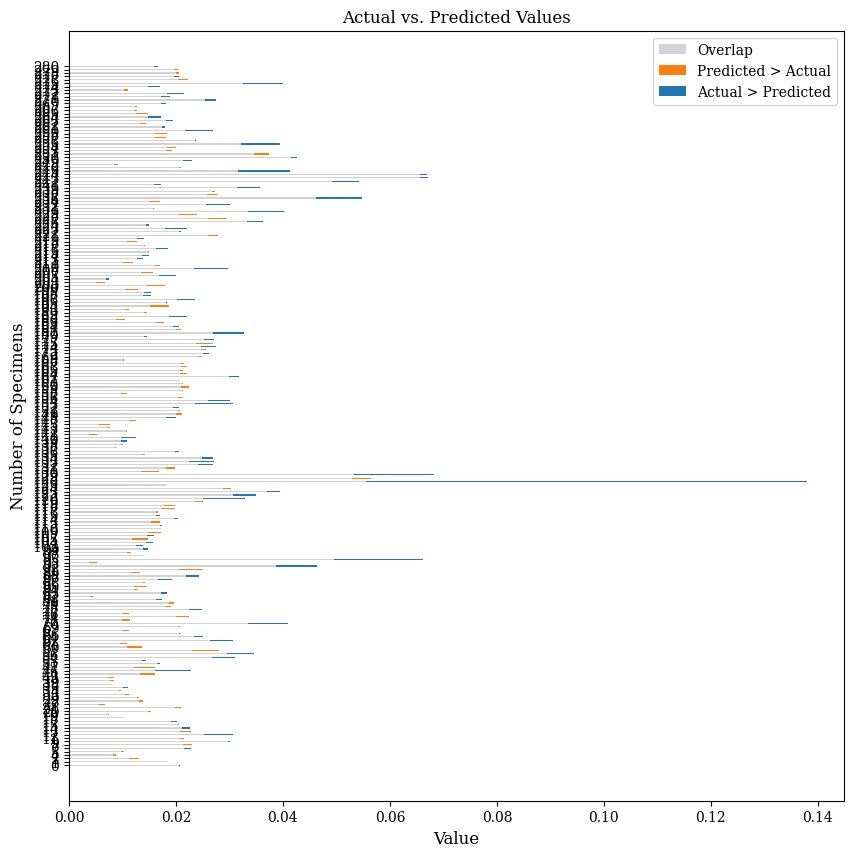

In [38]:
# Create a list of subject names
subjects = list(inverse_result1.index)
predicted=inverse_result1.iloc[:,3]
actual=inverse_result1.iloc[:,2]
# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(subjects))

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=10)

# Create bars for the overlapping part in gray color
ax.barh(r1, np.minimum(predicted, actual), height=bar_width, color='lightgray', label='Overlap')
# Create bars for the predicted values larger than actual values in orange color
ax.barh(r1, np.maximum(predicted - actual, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:orange', label='Predicted > Actual')
# Create bars for the actual values larger than predicted values in blue color
ax.barh(r1, np.maximum(actual - predicted, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:blue', label='Actual > Predicted')

# Add labels, titles, and legends
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Number of Specimens',fontsize=12)
ax.set_title('Actual vs. Predicted Values',fontsize=12)
ax.set_yticks(r1)
ax.set_yticklabels(subjects)
ax.legend()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


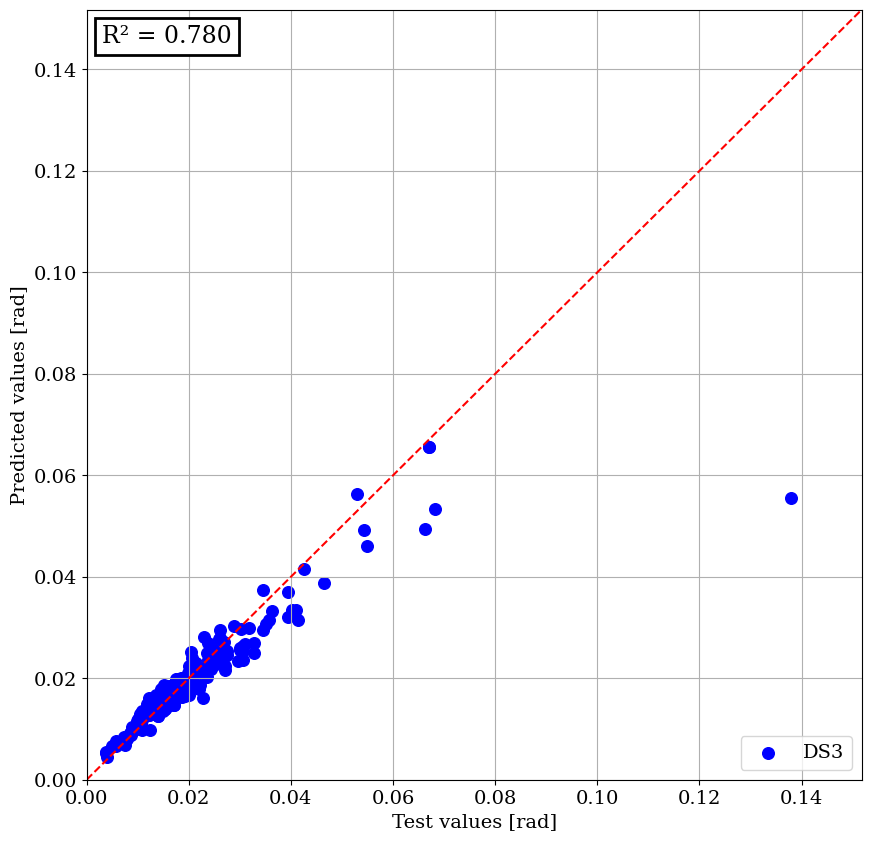

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
guide = np.max(np.max(inverse_result1.iloc[:,2:4]))*1.1
line_data = [0.0, guide]
line_test = [0.0, guide * 0.75]
plt.figure(figsize=(10, 10))
plt.rc('font', size=14)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

ax = plt.scatter(actual_values, predicted_values, color="blue", s=70)
ax.set_label(target_name[target_num])
plt.xlabel("Test values ​​[rad]")
plt.ylabel("Predicted values ​​[rad]")

plt.plot(line_data, line_data, color="red", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()

bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² = {r_squared:.3f}", fontsize=17,
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")

plt.show()


## test set

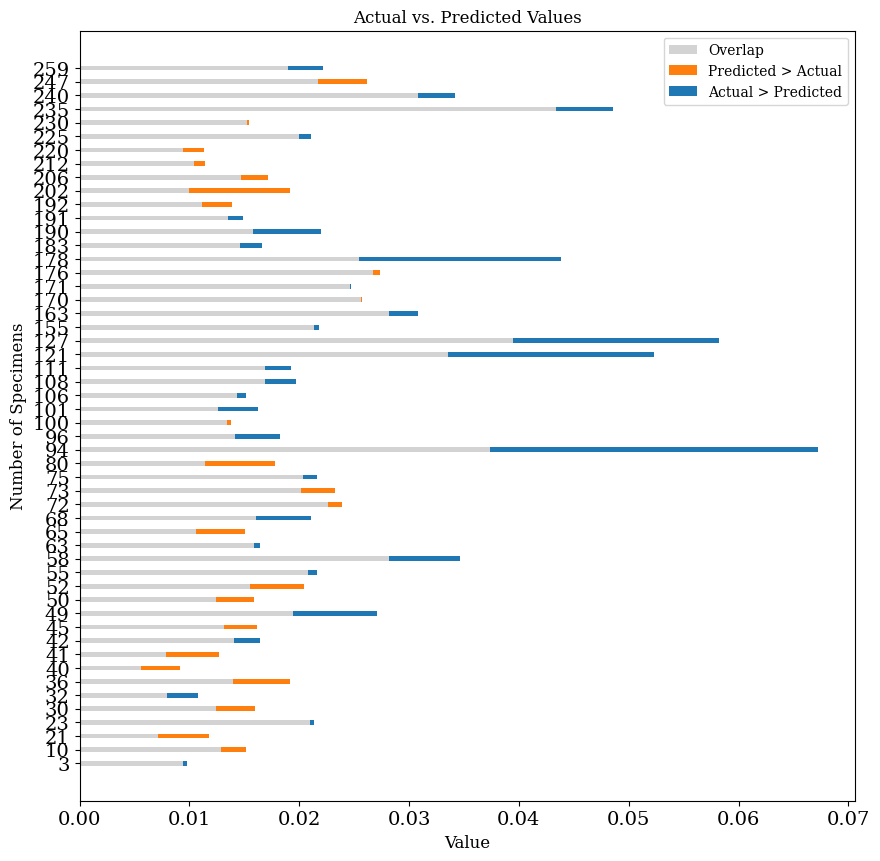

In [40]:
# Create a list of subject names
subjects = list(inverse_result2.index)
predicted=inverse_result2.iloc[:,3]
actual=inverse_result2.iloc[:,2]
# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(subjects))

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=10)

# Create bars for the overlapping part in gray color
ax.barh(r1, np.minimum(predicted, actual), height=bar_width, color='lightgray', label='Overlap')
# Create bars for the predicted values larger than actual values in orange color
ax.barh(r1, np.maximum(predicted - actual, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:orange', label='Predicted > Actual')
# Create bars for the actual values larger than predicted values in blue color
ax.barh(r1, np.maximum(actual - predicted, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:blue', label='Actual > Predicted')

# Add labels, titles, and legends
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Number of Specimens',fontsize=12)
ax.set_title('Actual vs. Predicted Values',fontsize=12)
ax.set_yticks(r1)
ax.set_yticklabels(subjects)
ax.legend()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


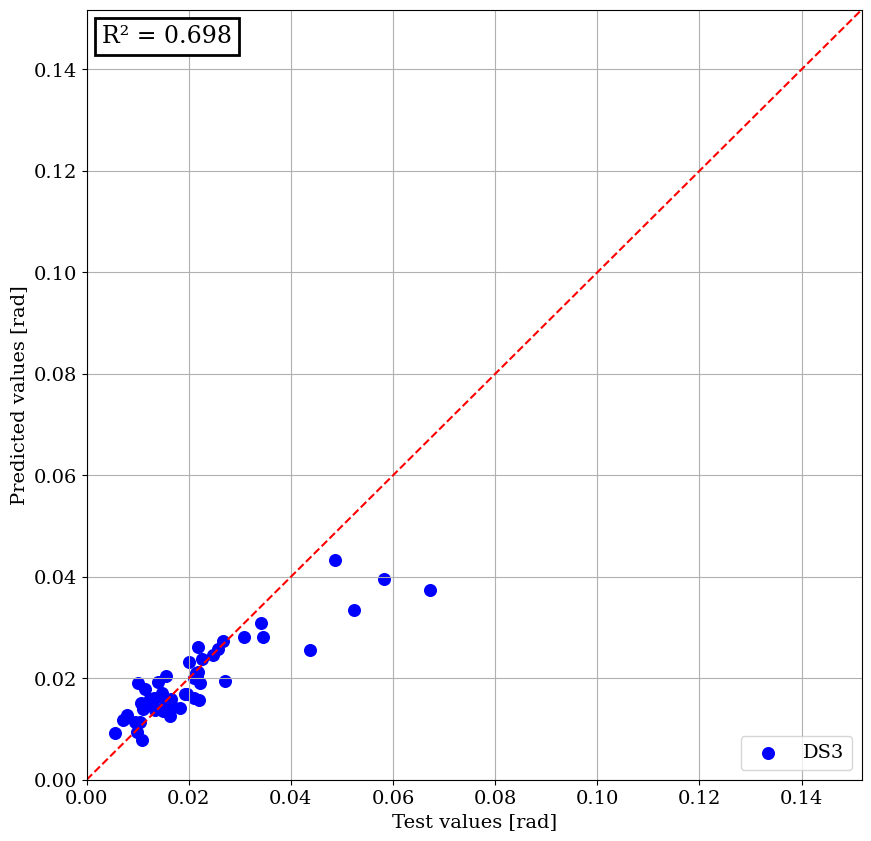

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
guide = np.max(np.max(inverse_result1.iloc[:,2:4]))*1.1
line_data = [0.0, guide]
line_test = [0.0, guide * 0.75]
plt.figure(figsize=(10, 10))
plt.rc('font', size=14)
plt.margins(x=0, y=0)

actual_values = inverse_result2.iloc[:,2]
predicted_values = inverse_result2.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

ax = plt.scatter(actual_values, predicted_values, color="blue", s=70)
ax.set_label(target_name[target_num])
plt.xlabel("Test values ​​[rad]")
plt.ylabel("Predicted values ​​[rad]")

plt.plot(line_data, line_data, color="red", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()

bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² = {r_squared:.3f}", fontsize=17,
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")

plt.show()
